# Bibliotecas e Ambiente

In [ ]:
# !pip install -r requirements.txt

# import capymoa
# print(capymoa.__version__)

In [1]:
import warnings
from datetime import datetime
import numpy as np
import pandas as pd
from capymoa.classifier import (
    LeveragingBagging,
    HoeffdingTree,
    HoeffdingAdaptiveTree,
    AdaptiveRandomForestClassifier,
)
from capymoa.evaluation import (
    ClassificationEvaluator,
    prequential_evaluation, 
    ClassificationWindowedEvaluator,
    prequential_evaluation_multiple_learners,
    prequential_ssl_evaluation
)
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.stream import NumpyStream
from sklearn.preprocessing import LabelEncoder
from py.functions import plot_confusion_matrix, criar_stream
import random
from collections import deque
from capymoa.drift.detectors import DDM, ADWIN, ABCD

# Visualização
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de Avisos 
warnings.filterwarnings('ignore')

# Stream

## Real

### CICDDoS2019

In [162]:
from py.functions import criar_stream

FILE_RAW = r'datasets\CICDDoS2019\CICDDoS2019_01_12.csv'
# FILE_RAW = r'datasets\CICDDoS2019\CICDDoS2019_03_11.csv'

TARGET_COL = " Label" # Ajuste se for o CIC-IDS2017 (sem espaço)
TIME_COL = " Timestamp" # Ajuste se for o CIC-IDS2017 (não existe)

# Colunas a serem removidas 
COLS_NAO_FEATURES = [
    'Flow ID', 
    ' Source IP', 
    ' Source Port',
    ' Destination IP', 
    ' Destination Port',
    ' Protocol'
]

TOP_20_FEATURES = [
    'Bwd Packet Length Max',
    'Min Packet Length',
    'Max Packet Length',
    'Packet Length Mean',
    'Packet Length Std',
    'Flow IAT Max',
    'Flow IAT Mean',
    'ACK Flag Count',
    'Fwd Packet Length Max',
    'Fwd Packet Length Mean',
    'Bwd Packet Length Mean',
    'Bwd Packet Length Std',
    'Init_Win_bytes_backward',
    'Bwd Packets/s',
    'Subflow Fwd Bytes',
    'Subflow Bwd Bytes',
    'Flow IAT Std',
    'Fwd IAT Total',
    'Init_Win_bytes_forward',
    'Avg Bwd Segment Size'
]

# Esta função única faz todo o trabalho de Carga, Limpeza, Ordenação e Criação
CICDDoS2019, le_global = criar_stream(
    file_path=FILE_RAW,
    target_label_col=TARGET_COL,
    timestamp_col=TIME_COL,
    cols_para_remover=COLS_NAO_FEATURES,
    features_selecionadas=TOP_20_FEATURES
)

--- Iniciando Pipeline: datasets\CICDDoS2019\CICDDoS2019_01_12.csv ---
  [Passo 2/6] Colunas renomeadas.
  [Passo 3/6] Ordenando DataFrame por 'Timestamp'...
  [Passo 4/6] Convertendo valores Infinitos para NaN...
  [Passo 5/6] Removendo colunas, tratando nulos e codificando rótulos...
    - LabelEncoder criado e ajustado. 12 classes encontradas.
    - 7 colunas removidas do conjunto de features.
    - Imputando 2532 valores nulos/infinitos com a MEDIANA...
    - Aplicando seleção de features. Mantendo 20 colunas.
  [Passo 6/6] Criando objeto NumpyStream...
    - Dados finais preparados: X_shape=(88803, 20), y_shape=(88803,).
Stream criado e pronto para uso.


## Sintética

In [ ]:
from capymoa.stream.drift import DriftStream, AbruptDrift, GradualDrift
from capymoa.stream.generator import (
    RandomTreeGenerator, 
    SEA, 
    RandomRBFGenerator, 
    RandomRBFGeneratorDrift
)

# Hyperparâmetros padrão
streams = {
    "RTG": RandomTreeGenerator(
        instance_random_seed=1,
        tree_random_seed=1,
        num_classes=2,
        num_nominals=5,
        num_numerics=5,
        num_vals_per_nominal=5,
        max_tree_depth=5,
        first_leaf_level=3,
        leaf_fraction=0.15,
    ),
    
    "RTG_drift": DriftStream(
        stream=[
            RandomTreeGenerator(tree_random_seed=1),
            AbruptDrift(position=1000),
            RandomTreeGenerator(tree_random_seed=2),
            GradualDrift(position=2000, width=500),
            RandomTreeGenerator(tree_random_seed=2),
            AbruptDrift(position=3000),
            RandomTreeGenerator(tree_random_seed=2),
        ]
    ),

    "SEA_drift": DriftStream(
        stream=[
            SEA(function=1),
            AbruptDrift(position=1000),
            SEA(function=2),
            AbruptDrift(position=2000),
            SEA(function=3),
            GradualDrift(position=3000, width=500),
            SEA(function=4),
        ]
    ),

    "RandomRBF": RandomRBFGenerator(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
    ), 

    "RandomRBF_drift": RandomRBFGeneratorDrift(
        model_random_seed=1,
        instance_random_seed=1,
        number_of_classes=2,
        number_of_attributes=10,
        number_of_centroids=50,
        number_of_drifting_centroids=4,
        magnitude_of_change=0.0,
    ),

    "Robust_Drift": DriftStream(
        stream=[
            # 0-2000
            RandomRBFGenerator(
                model_random_seed=1, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=50
            ),
            # 2000-4000 (Testa DDM/ADWIN)
            AbruptDrift(position=2000),
            RandomTreeGenerator(
                tree_random_seed=1, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 4000-6000 (Testa ABCD)
            AbruptDrift(position=4000),
            RandomRBFGenerator(
                model_random_seed=2, 
                instance_random_seed=1, 
                number_of_classes=2, 
                number_of_attributes=10, 
                number_of_centroids=20
            ),
            # 6000-8000 (Testa DDM/ADWIN)
            AbruptDrift(position=6000),
            RandomTreeGenerator(
                tree_random_seed=2, 
                instance_random_seed=1, 
                num_classes=2, 
                num_nominals=0, 
                num_numerics=10
            ),
            # 8000-10000 (Testa ABCD)
            GradualDrift(position=8000, width=1000),
            RandomRBFGeneratorDrift(
                model_random_seed=4, 
                instance_random_seed=1, 
                number_of_attributes=10, 
                number_of_drifting_centroids=20, 
                magnitude_of_change=0.5
            )
        ]
    )

}

# Algoritmos de Stream Mining

## Leveraging Bagging (LB) 

https://capymoa.org/api/modules/capymoa.classifier.LeveragingBagging.html

* **Schema** – O esquema do fluxo. Se não for fornecido, será inferido a partir dos dados.
* **CLI** – Opções da Interface de Linha de Comando (CLI) para configurar o algoritmo ARF. Se não forem fornecidas, as opções padrão serão utilizadas.
* **random_seed** – Semente para o gerador de números aleatórios.
* **base_learner** – O modelo base a ser usado. Se não for fornecido, uma árvore de Hoeffding padrão será utilizada.
* **ensemble_size** – O número de árvores no conjunto.
* **minibatch_size** – O número de instâncias que um algoritmo de aprendizado deve acumular antes do treinamento.
* **number_of_jobs** – O número de tarefas paralelas a serem executadas durante a execução do algoritmo. Por padrão, o algoritmo executa as tarefas sequencialmente (ou seja, com `number_of_jobs=1` ). Aumentar o valor de `number_of_jobs` pode levar a uma execução mais rápida em sistemas com múltiplos núcleos. No entanto, definir um valor alto pode consumir mais recursos do sistema e memória. Esta implementação prioriza o desempenho, portanto, o desempenho preditivo é modificado. Recomenda-se experimentar com diferentes valores para encontrar a configuração ideal com base nos recursos de hardware disponíveis e na natureza da carga de trabalho.

### Hiperparâmetros

In [34]:
MAX_INSTANCES = 10000
WINDOW_SIZE = 500
DELAY_LENGTH = 500
LABEL_PROBABILITY = 0.50

# Para alterar entre as streams sintética e real
stream = streams["Robust_Drift"]
print(stream.get_schema())

LB = LeveragingBagging(
    schema=stream.schema, 
    CLI=None, # Padrão (None)
    random_seed=1, # Padrão (1)
    base_learner=None, # Padrão (None)
    ensemble_size=100, # Padrão (100)
    minibatch_size=None, # Padrão (None)
    number_of_jobs=None # Padrão (None)
)

classificationEvaluatorLB = ClassificationEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)
windowedEvaluatorLB = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)

drift_detector_DDM = DDM()
drift_detector_ADWIN = ADWIN()

@relation 'generators.RandomRBFGenerator '

@attribute att1 numeric
@attribute att2 numeric
@attribute att3 numeric
@attribute att4 numeric
@attribute att5 numeric
@attribute att6 numeric
@attribute att7 numeric
@attribute att8 numeric
@attribute att9 numeric
@attribute att10 numeric
@attribute class {class1,class2}

@data


### LB - Supervisionado

Resultados Cumulativos
Accuracy: 77.22
F1_Score: 76.66931372541525


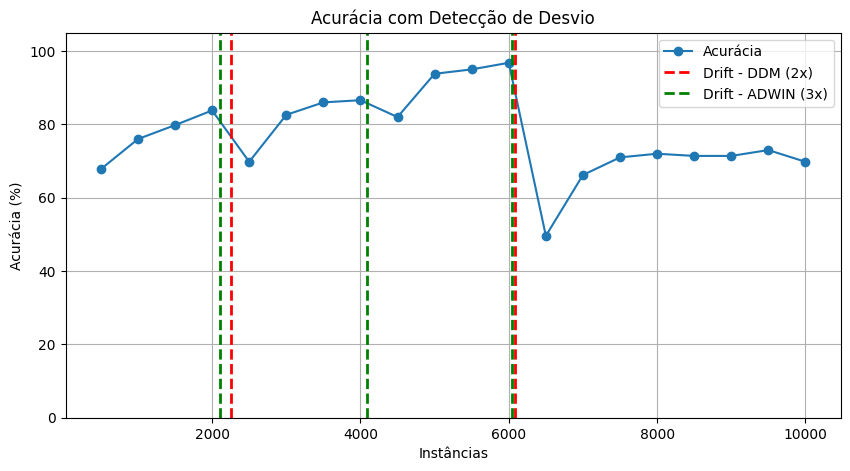

In [35]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    prediction = LB.predict(instance)
    
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    classificationEvaluatorLB.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    LB.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorLB.accuracy()}")
print(f"F1_Score: {classificationEvaluatorLB.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(10, 5))
plt.plot(instance_count_history, window_accuracy_history, 'o-', label='Acurácia')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=2, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='--', 
           linewidth=2, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia com Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True)
plt.legend()
plt.show()

Supervisionado
Accuracy: 79.47999999999999
f1_score: 78.86646723011643


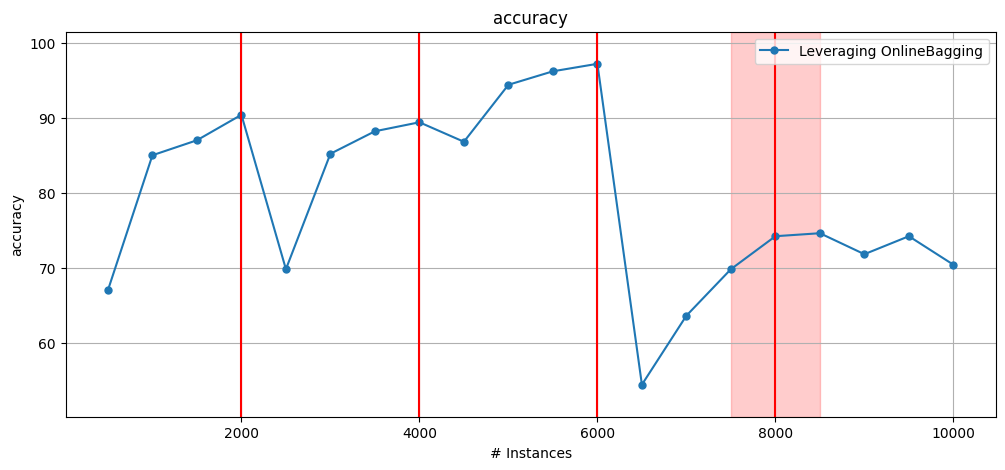

In [36]:
# Hyperparâmetros padrão
result_prequential = prequential_evaluation(
    stream=stream,
    learner=LB,
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("Supervisionado")
print("Accuracy:", result_prequential['cumulative'].accuracy())
print("f1_score:", result_prequential['cumulative'].f1_score())
# display(result_prequential['windowed'].metrics_per_window())
plot_windowed_results(result_prequential, metric="accuracy")

### LB - Semi-supervised Learning (SSL)

Resultados Cumulativos
Accuracy: 78.245
F1_Score: 77.61074324264098


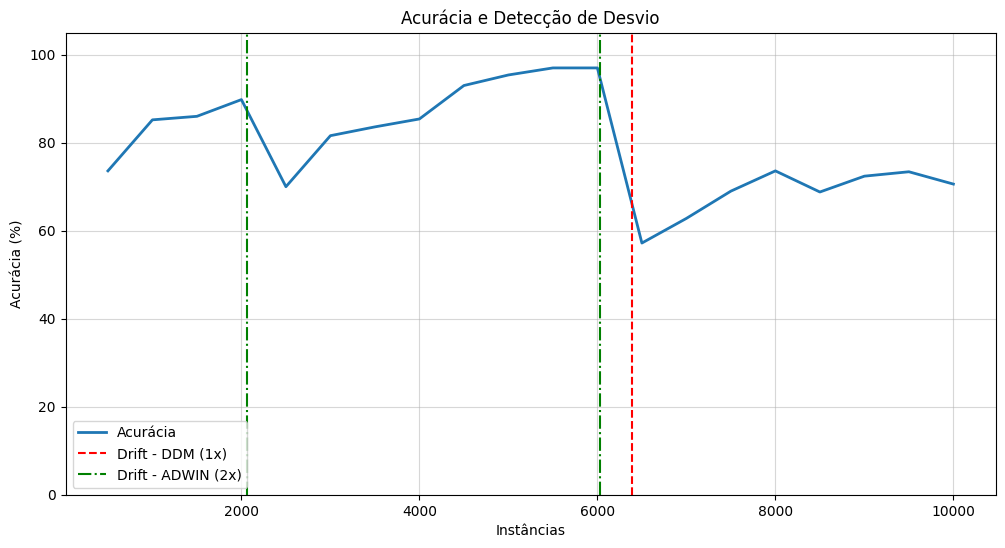

In [37]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # Ocorre imediatamente
    prediction = LB.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente
    classificationEvaluatorLB.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Se a instância for selecionada aleatoriamente (LABEL_PROBABILITY),
    # o modelo treina. Caso contrário, o treino é pulado.
    if random.random() <= LABEL_PROBABILITY:
        LB.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1


print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorLB.accuracy()}")
print(f"F1_Score: {classificationEvaluatorLB.f1_score()}")

plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label=f'Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title(f'Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

SSL
Accuracy: 80.33
f1_score: 79.78391548399136


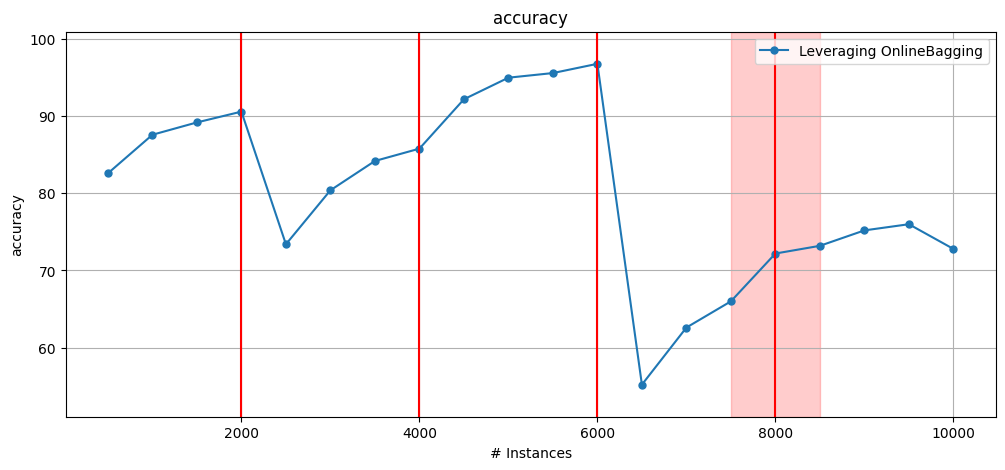

In [38]:
# Hyperparâmetros padrão para SSL
result_ssl_prequential = prequential_ssl_evaluation(
    stream=stream, 
    learner=LB, 
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    initial_window_size=0,
    delay_length=0,
    label_probability=LABEL_PROBABILITY,
    random_seed=1,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("SSL")
print("Accuracy:", result_ssl_prequential['cumulative'].accuracy())
print("f1_score:", result_ssl_prequential['cumulative'].f1_score())
# display(result_ssl_prequential['windowed'].metrics_per_window())
plot_windowed_results(result_ssl_prequential, metric="accuracy")


### LB - SSL com Delay

Resultados Cumulativos
Accuracy: 78.09
F1_Score: 77.41943508580383


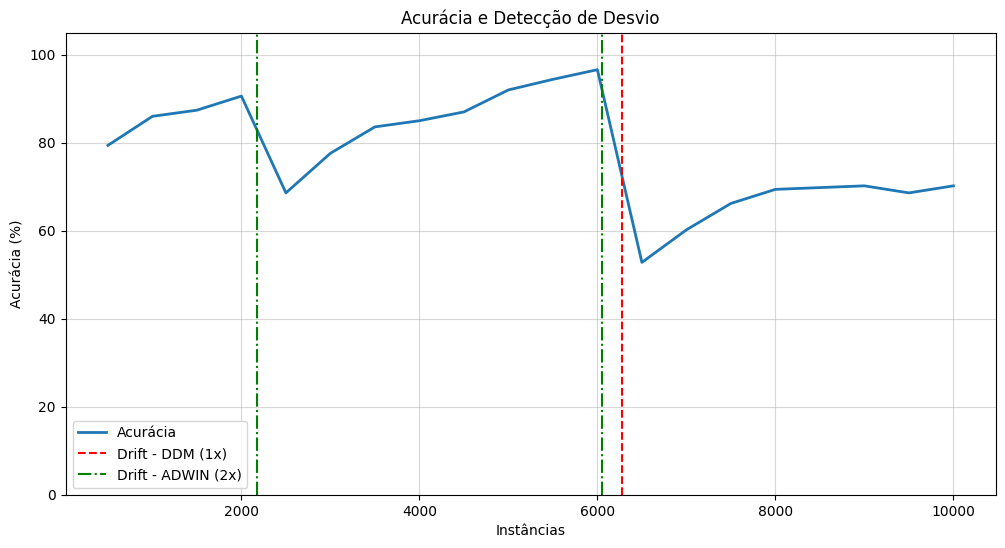

In [39]:
# Fila para armazenar instâncias para treino atrasado
prediction_queue = deque(maxlen=DELAY_LENGTH) 

window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE)  
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # (Predict) - Ocorre imediatamente
    prediction = LB.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente com o rótulo conhecido
    classificationEvaluatorLB.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN 
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Determina se o rótulo está disponível (SSL)
    if random.random() <= LABEL_PROBABILITY:
        # Rótulo disponível: Armazenamos a instância completa para treino futuro
        prediction_queue.append(instance) 
    else:
        # Rótulo NÃO disponível: Armazenamos None para manter o delay
        prediction_queue.append(None)
        
    # TREINO ATRASADO (Delayed Train)
    if len(prediction_queue) == DELAY_LENGTH:
        delayed_item = prediction_queue.popleft()
        
        # Só treina se o rótulo estiver disponível no item que saiu da fila
        if delayed_item is not None:
            LB.train(delayed_item)
            # print(f"Treinado na instância {count - DELAY_LENGTH + 1} com rótulo disponível.")
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorLB.accuracy()}")
print(f"F1_Score: {classificationEvaluatorLB.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label='Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

### Comparação dos Resultados

Foi comentado o result_ssl_prequential_delay, pois ainda não foi implementado no capyMOA (Delay e o Tamanho da Janela Inicial)

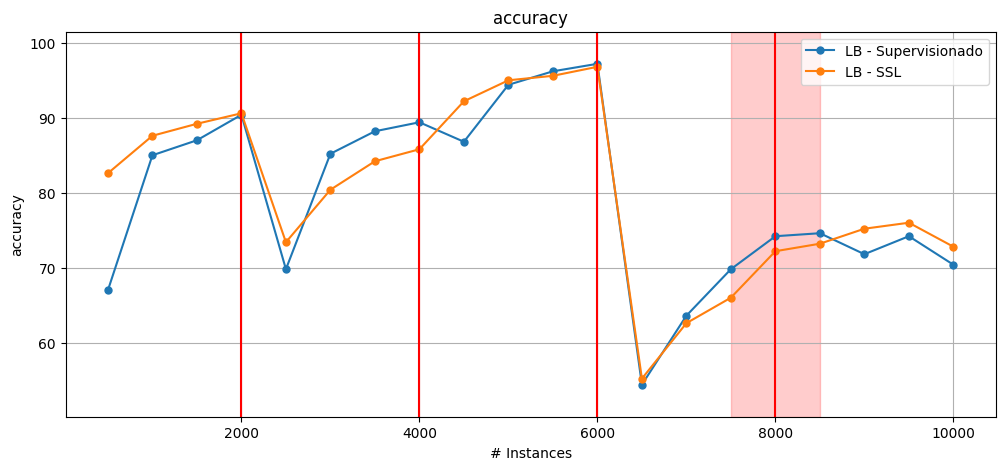

In [40]:
# Rótulos para os gráficos
result_prequential.learner = "LB - Supervisionado"
result_ssl_prequential.learner = "LB - SSL"
# result_ssl_prequential_delay.learner = "LB - SSL com Delay"

# Plot dos resultados
plot_windowed_results(
    result_prequential, 
    result_ssl_prequential, 
    # result_ssl_prequential_delay, 
    metric="accuracy"
)

## Hoeffding Adaptive Tree (HAT)

https://capymoa.org/api/modules/capymoa.classifier.HoeffdingAdaptiveTree.html

* **schema** - o esquema do fluxo.
* **random_seed** – a semente aleatória passada para o algoritmo de aprendizado do Moa.
* **grace_period** – o número de instâncias que uma folha deve observar entre as tentativas de divisão.
* **split_criterion** – o critério de divisão a ser usado. O padrão é InfoGainSplitCriterion .
* **confidence**  – o nível de confiança para calcular o Limite de Hoeffding (1 - delta). O valor padrão é 1e-3 . Valores mais próximos de zero implicam em maiores atrasos na decisão dividida.
* **tie_threshold** – o limite abaixo do qual uma divisão será forçada para desempatar.
* **leaf_prediction** – o mecanismo de predição usado nas folhas.
    * 0 - Classe majoritária
    * 1 - Naive Bayes
    * 2 - Naive Bayes adaptativo

* **nb_threshold** – o número de instâncias que uma folha deve observar antes de permitir o Naive Bayes.
* **numeric_attribute_observer** – o Splitter ou Observador de Atributos (AO) usado para monitorar as estatísticas de classe de recursos numéricos e realizar divisões.
* **binary_split** – Se verdadeiro, permite apenas divisões binárias.
* **max_byte_size** – o tamanho máximo da árvore, em bytes.
* **memory_estimate_period** – Intervalo (número de instâncias processadas) entre as verificações de consumo de memória.
* **stop_mem_management** – ​​Se verdadeiro, interrompe o crescimento assim que o limite de memória for atingido.
* **remove_poor_attrs** – Se verdadeiro, desativa atributos de baixa qualidade para reduzir o uso de memória.
* **disable_prepruning** – Se verdadeiro, desativa a pré-poda de árvores baseada em mérito.

### Hiperparâmetros

In [145]:
MAX_INSTANCES = 8000
WINDOW_SIZE = 100
DELAY_LENGTH = 300
LABEL_PROBABILITY = 0.1

HAT = HoeffdingAdaptiveTree(
    schema=stream.schema,
    random_seed=0, # Padrão (0)
    grace_period=200, # Padrão (200)
    split_criterion='InfoGainSplitCriterion', # Padrão ('InfoGainSplitCriterion')
    confidence=0.01, # Padrão (0.01)
    tie_threshold=0.05, # Padrão (0.05)
    leaf_prediction='NaiveBayesAdaptive',
    nb_threshold=0, # Padrão (0)
    numeric_attribute_observer='GaussianNumericAttributeClassObserver', # Padrão ('GaussianNumericAttributeClassObserver')
    binary_split=False, # Padrão (False)
    max_byte_size=33554432, # Padrão (32MB)
    memory_estimate_period=1000000, # Padrão (1.000.000)
    stop_mem_management=True, # Padrão (True)
    remove_poor_attrs=False, # Padrão (False)
    disable_prepruning=True # Padrão (True)
)

classificationEvaluatorHAT = ClassificationEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)
windowedEvaluatorHAT = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)

drift_detector_DDM = DDM()
drift_detector_ADWIN = ADWIN()

# Para alterar entre as streams sintética e real
stream = streams["SEA_drift"]
print(stream.get_schema())

@relation 'generators.SEAGenerator '

@attribute attrib1 numeric
@attribute attrib2 numeric
@attribute attrib3 numeric
@attribute class {groupA,groupB}

@data


### HAT - Supervisionado

Resultados Cumulativos
Accuracy: 84.5875
F1_Score: 83.80268632455618


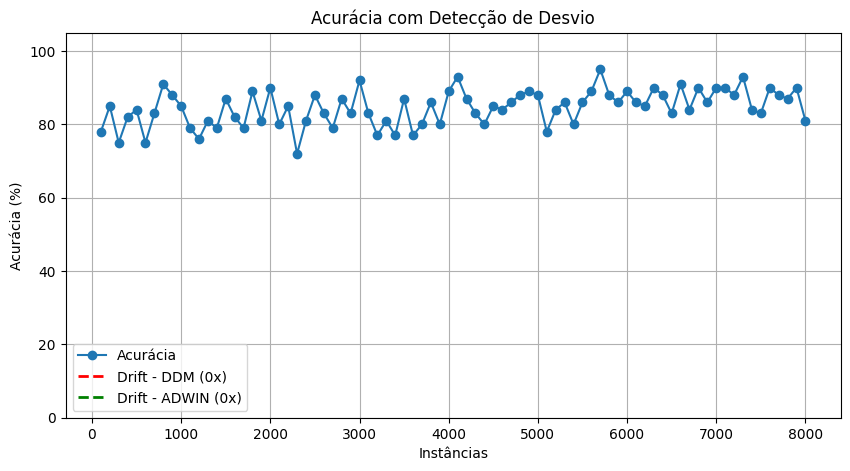

In [148]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    prediction = HAT.predict(instance)
    
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    classificationEvaluatorHAT.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    HAT.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorHAT.accuracy()}")
print(f"F1_Score: {classificationEvaluatorHAT.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(10, 5))
plt.plot(instance_count_history, window_accuracy_history, 'o-', label='Acurácia')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=2, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='--', 
           linewidth=2, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia com Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True)
plt.legend()
plt.show()

Supervisionado
Accuracy: 84.475
f1_score: 83.81040707932519


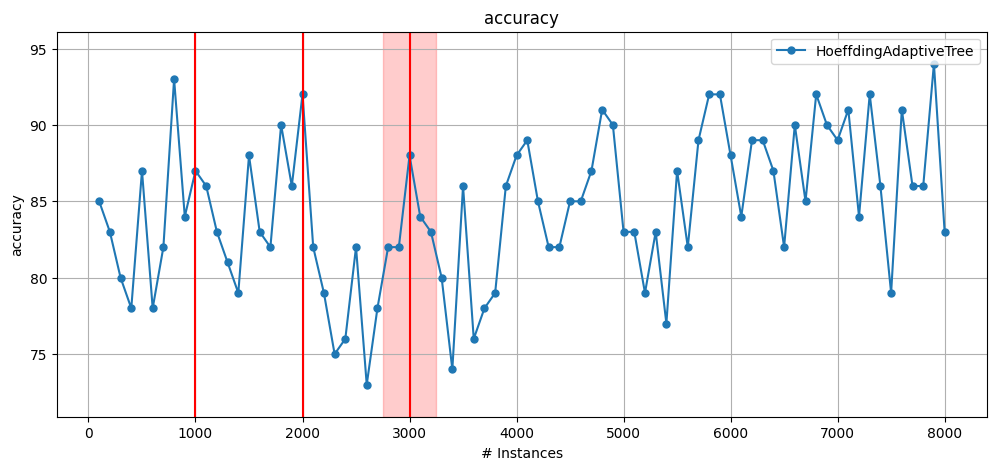

In [149]:
# Hyperparâmetros padrão
result_prequential_HAT = prequential_evaluation(
    stream=stream,
    learner=HAT,
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("Supervisionado")
print("Accuracy:", result_prequential_HAT['cumulative'].accuracy())
print("f1_score:", result_prequential_HAT['cumulative'].f1_score())
# display(result_prequential_HAT['windowed'].metrics_per_window())
plot_windowed_results(result_prequential_HAT, metric="accuracy")

### HAT - Semi-supervised Learning (SSL)

Resultados Cumulativos
Accuracy: 84.975
F1_Score: 84.24328904751408


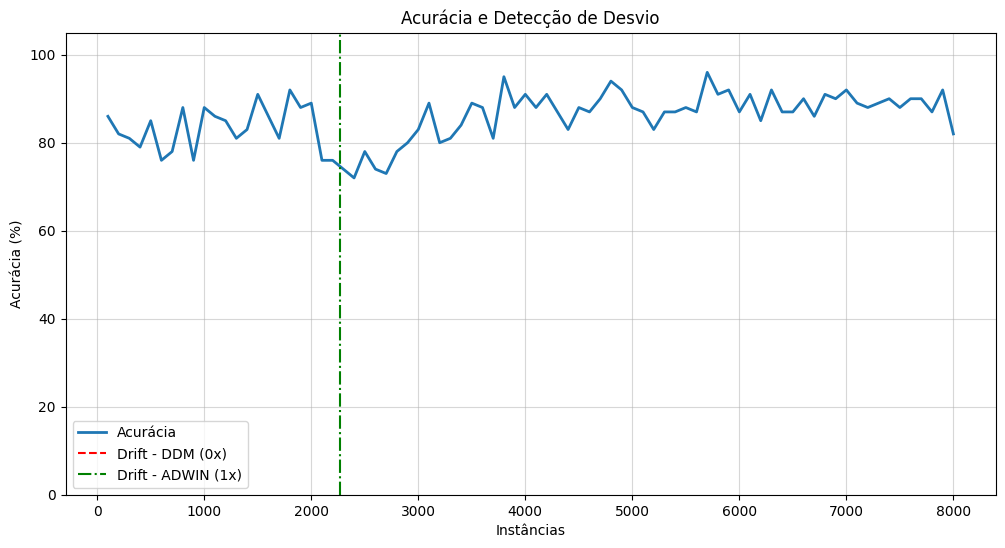

In [93]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # Ocorre imediatamente
    prediction = HAT.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente
    classificationEvaluatorHAT.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Se a instância for selecionada aleatoriamente (LABEL_PROBABILITY),
    # o modelo treina. Caso contrário, o treino é pulado.
    if random.random() <= LABEL_PROBABILITY:
        HAT.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1


print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorHAT.accuracy()}")
print(f"F1_Score: {classificationEvaluatorHAT.f1_score()}")

plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label=f'Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title(f'Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

SSL
Accuracy: 82.8625
f1_score: 81.97534745226992


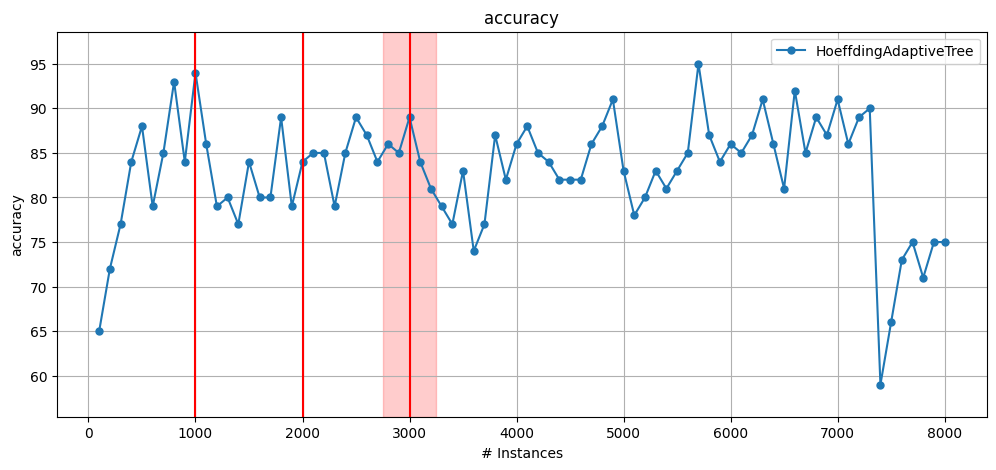

In [146]:
# Hyperparâmetros padrão para SSL
result_ssl_prequential_HAT = prequential_ssl_evaluation(
    stream=stream, 
    learner=HAT, 
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    initial_window_size=0,
    delay_length=0,
    label_probability=LABEL_PROBABILITY,
    random_seed=1,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("SSL")
print("Accuracy:", result_ssl_prequential_HAT['cumulative'].accuracy())
print("f1_score:", result_ssl_prequential_HAT['cumulative'].f1_score())
# display(result_ssl_prequential_HAT['windowed'].metrics_per_window())
plot_windowed_results(result_ssl_prequential_HAT, metric="accuracy")


### HAT - SSL com Delay

Resultados Cumulativos
Accuracy: 81.81538461538462
F1_Score: 81.46247363522566


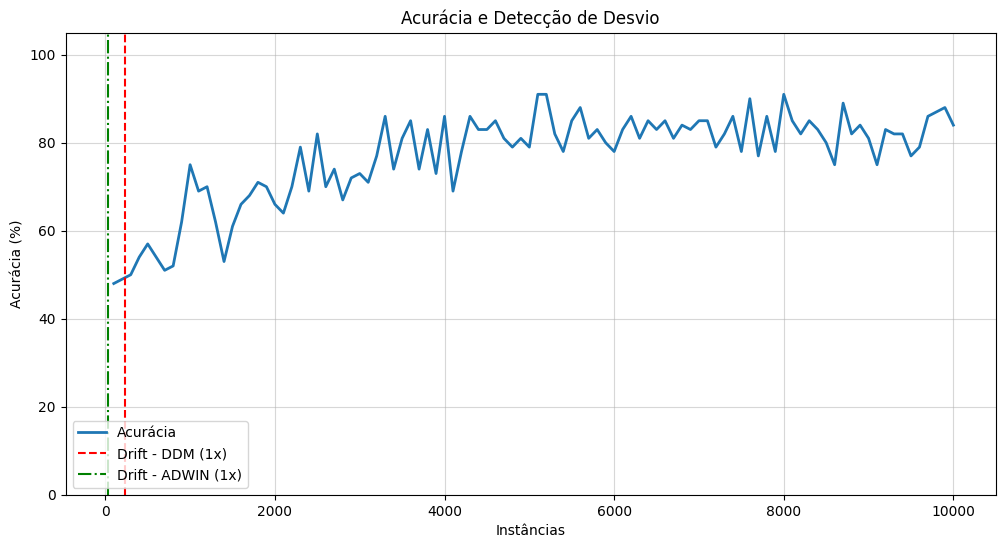

In [125]:
# Fila para armazenar instâncias para treino atrasado
prediction_queue = deque(maxlen=DELAY_LENGTH) 

window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE)  
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # (Predict) - Ocorre imediatamente
    prediction = HAT.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente com o rótulo conhecido
    classificationEvaluatorHAT.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN 
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Determina se o rótulo está disponível (SSL)
    if random.random() <= LABEL_PROBABILITY:
        # Rótulo disponível: Armazenamos a instância completa para treino futuro
        prediction_queue.append(instance) 
    else:
        # Rótulo NÃO disponível: Armazenamos None para manter o delay
        prediction_queue.append(None)
        
    # TREINO ATRASADO (Delayed Train)
    if len(prediction_queue) == DELAY_LENGTH:
        delayed_item = prediction_queue.popleft()
        
        # Só treina se o rótulo estiver disponível no item que saiu da fila
        if delayed_item is not None:
            HAT.train(delayed_item)
            # print(f"Treinado na instância {count - DELAY_LENGTH + 1} com rótulo disponível.")
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorHAT.accuracy()}")
print(f"F1_Score: {classificationEvaluatorHAT.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label='Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

### Comparação dos Resultados

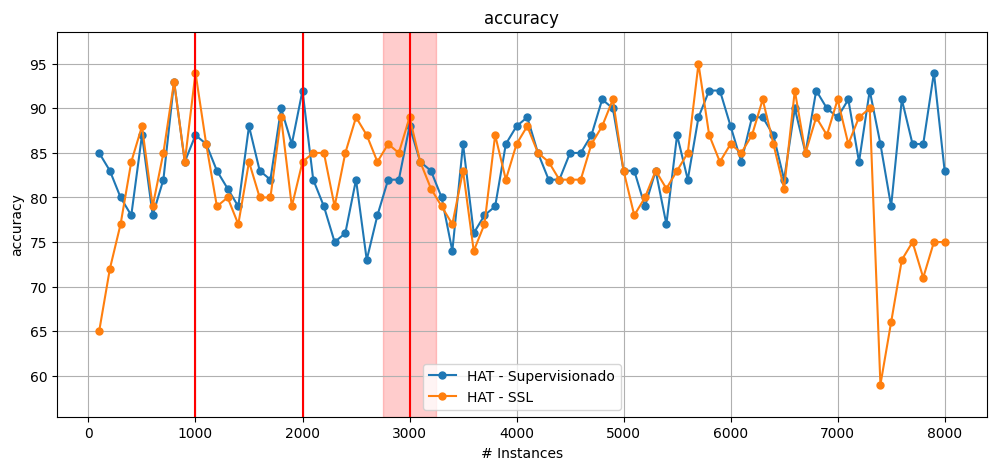

In [150]:
# Rótulos para os gráficos
result_prequential_HAT.learner = "HAT - Supervisionado"
result_ssl_prequential_HAT.learner = "HAT - SSL"

# Plot dos resultados
plot_windowed_results(
    result_prequential_HAT, 
    result_ssl_prequential_HAT,  
    metric="accuracy"
)

## Adaptive Random Forest (ARF)

https://capymoa.org/api/modules/capymoa.classifier.AdaptiveRandomForestClassifier.html#capymoa.classifier.AdaptiveRandomForestClassifier

* **schema** – O esquema do fluxo. Se não for fornecido, será inferido a partir dos dados.
* **CLI** – Opções da Interface de Linha de Comando (CLI) para configurar o algoritmo ARF. Se não forem fornecidas, as opções padrão serão utilizadas.
* **random_seed** – Semente para o gerador de números aleatórios.
* **base_learner** – O modelo base a ser usado. Se não for fornecido, uma árvore de Hoeffding padrão será utilizada.
* **ensemble_size** – O número de árvores no conjunto.
* **max_features** – O número máximo de características a serem consideradas ao dividir um nó. Se fornecido como um número de ponto flutuante entre 0,0 e 1,0, representa a porcentagem de características a serem consideradas. Se fornecido como um número inteiro, especifica o número exato de características a serem consideradas. Se fornecido como a string “sqrt”, indica a raiz quadrada do número total de características. Se não for fornecido, o valor padrão é 60%.
* **lambda_param** – O parâmetro lambda que controla a distribuição de Poisson para a simulação de bagging online.
* **minibatch_size** – O número de instâncias que um algoritmo de aprendizado deve acumular antes do treinamento.
* **number_of_jobs** – O número de tarefas paralelas a serem executadas durante a execução do algoritmo. Por padrão, o algoritmo executa as tarefas sequencialmente (ou seja, com `number_of_jobs=1` ). Aumentar o valor de `number_of_jobs` pode levar a uma execução mais rápida em sistemas com múltiplos núcleos. No entanto, definir um valor alto pode consumir mais recursos do sistema e memória. Esta implementação foi projetada para ser extremamente paralela, o que significa que os cálculos do algoritmo podem ser distribuídos eficientemente entre várias unidades de processamento sem sacrificar o desempenho preditivo. Recomenda-se experimentar com diferentes valores para encontrar a configuração ideal com base nos recursos de hardware disponíveis e na natureza da carga de trabalho.
* **drift_detection_method** – O método usado para detecção de deriva.
* **warning_detection_method** – O método usado para detecção de avisos.
* **disable_weighted_vote** – Indica se a votação ponderada deve ser desativada.
* **disable_drift_detection** – Indica se a detecção de deriva deve ser desativada.
* **disable_background_learner** – Indica se o aprendizado em segundo plano deve ser desativado.

### Hiperparâmetros

In [132]:
MAX_INSTANCES = 8000
WINDOW_SIZE = 100
DELAY_LENGTH = 300
LABEL_PROBABILITY = 0.1

ARF = AdaptiveRandomForestClassifier(
    schema=stream.schema,
    CLI=None, # Padrão (None)
    random_seed=1, # Padrão (1)
    base_learner=None, # Padrão (None)
    ensemble_size=100, # Padrão (100)
    max_features=0.6, # Padrão (0.6)
    lambda_param=6.0, # Padrão (6.0)
    minibatch_size=None, # Padrão (None)
    number_of_jobs=1, # Padrão (1)
    drift_detection_method=None, # Padrão (None)
    warning_detection_method=None, # Padrão (None)
    disable_weighted_vote=False, # Padrão (False)
    disable_drift_detection=False, # Padrão (False)
    disable_background_learner=False # Padrão (False)        
)

classificationEvaluatorARF = ClassificationEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)
windowedEvaluatorARF = ClassificationWindowedEvaluator(schema=stream.get_schema(), window_size=WINDOW_SIZE)

drift_detector_DDM = DDM()
drift_detector_ADWIN = ADWIN()

# Para alterar entre as streams sintética e real
stream = streams["SEA_drift"]
print(stream.get_schema())

@relation 'generators.SEAGenerator '

@attribute attrib1 numeric
@attribute attrib2 numeric
@attribute attrib3 numeric
@attribute class {groupA,groupB}

@data


### ARF - Supervisionado

Resultados Cumulativos
Accuracy: 86.1875
F1_Score: 85.50905257958802


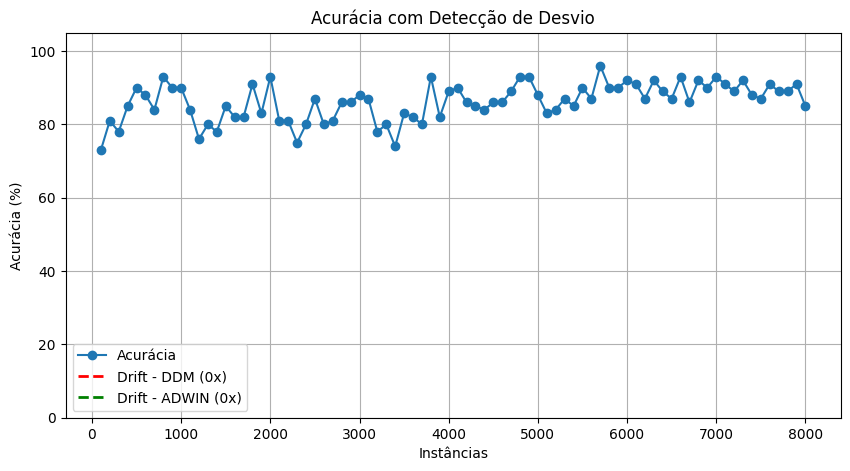

In [133]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    prediction = ARF.predict(instance)
    
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    classificationEvaluatorARF.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    ARF.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorARF.accuracy()}")
print(f"F1_Score: {classificationEvaluatorARF.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(10, 5))
plt.plot(instance_count_history, window_accuracy_history, 'o-', label='Acurácia')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=2, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='--', 
           linewidth=2, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia com Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True)
plt.legend()
plt.show()

Supervisionado
Accuracy: 86.7875
f1_score: 86.18938048633761


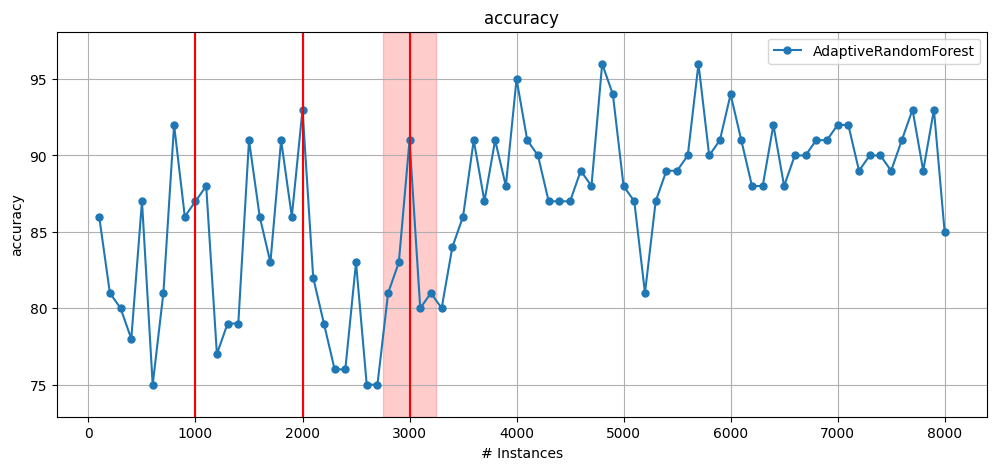

In [134]:
# Hyperparâmetros padrão
result_prequential_ARF = prequential_evaluation(
    stream=stream,
    learner=ARF,
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("Supervisionado")
print("Accuracy:", result_prequential_ARF['cumulative'].accuracy())
print("f1_score:", result_prequential_ARF['cumulative'].f1_score())
# display(result_prequential_ARF['windowed'].metrics_per_window())
plot_windowed_results(result_prequential_ARF, metric="accuracy")

### ARF - Semi-supervised Learning (SSL)

Resultados Cumulativos
Accuracy: 87.01875
F1_Score: 86.39849304753767


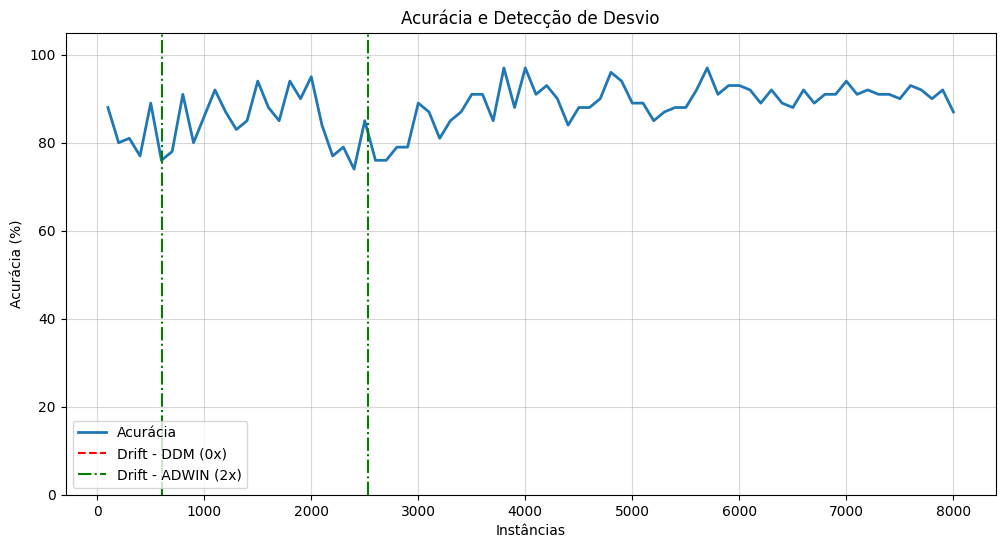

In [135]:
window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE) 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # Ocorre imediatamente
    prediction = ARF.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente
    classificationEvaluatorARF.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Se a instância for selecionada aleatoriamente (LABEL_PROBABILITY),
    # o modelo treina. Caso contrário, o treino é pulado.
    if random.random() <= LABEL_PROBABILITY:
        ARF.train(instance)
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1


print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorARF.accuracy()}")
print(f"F1_Score: {classificationEvaluatorARF.f1_score()}")

plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label=f'Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title(f'Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

SSL
Accuracy: 88.52499999999999
f1_score: 88.0581565530067


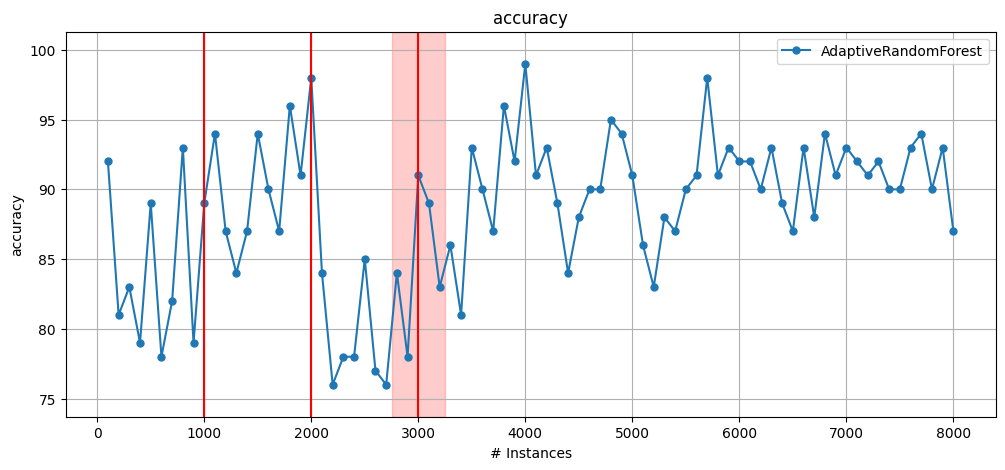

In [136]:
# Hyperparâmetros padrão para SSL
result_ssl_prequential_ARF = prequential_ssl_evaluation(
    stream=stream, 
    learner=ARF, 
    max_instances=MAX_INSTANCES,
    window_size=WINDOW_SIZE,
    initial_window_size=0,
    delay_length=0,
    label_probability=LABEL_PROBABILITY,
    random_seed=1,
    store_predictions=False,
    store_y=False,
    optimise=True,
    restart_stream=True,
    progress_bar=False,
    batch_size=1
)

print("SSL")
print("Accuracy:", result_ssl_prequential_ARF['cumulative'].accuracy())
print("f1_score:", result_ssl_prequential_ARF['cumulative'].f1_score())
# display(result_ssl_prequential_ARF['windowed'].metrics_per_window())
plot_windowed_results(result_ssl_prequential_ARF, metric="accuracy")


### ARF - SSL com Delay

Resultados Cumulativos
Accuracy: 87.60416666666667
F1_Score: 87.03418470987071


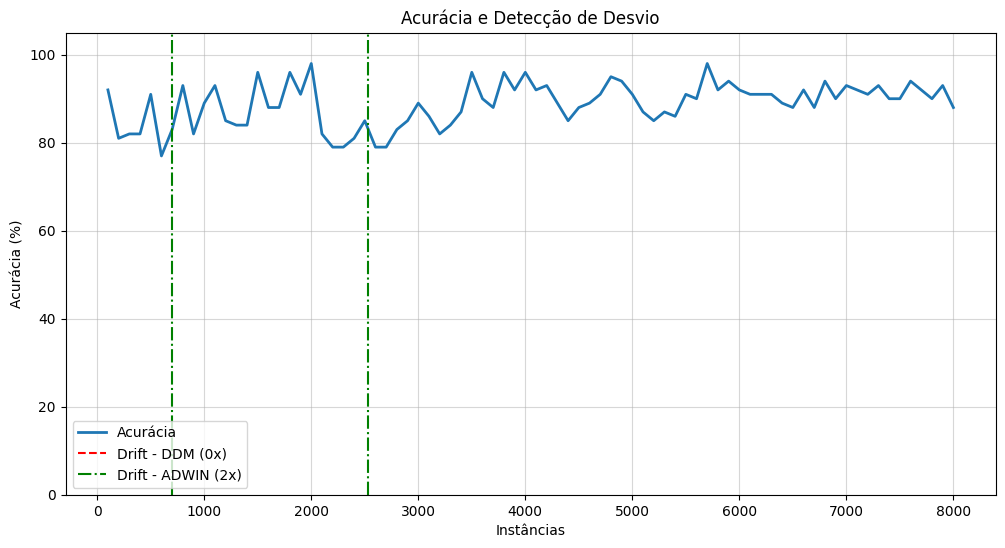

In [137]:
# Fila para armazenar instâncias para treino atrasado
prediction_queue = deque(maxlen=DELAY_LENGTH) 

window_accuracy_history = []
instance_count_history = []
drift_points_DDM = [] 
drift_points_ADWIN = [] 
window_errors = deque(maxlen=WINDOW_SIZE)  
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # (Predict) - Ocorre imediatamente
    prediction = ARF.predict(instance)
    
    # Garantindo que 'prediction_value' é um escalar
    try:
        prediction_value = prediction[0]
    except (IndexError, TypeError):
        prediction_value = prediction 
    
    # Acurácia é avaliada imediatamente com o rótulo conhecido
    classificationEvaluatorARF.update(instance.y_index, prediction_value)
    
    error = 0 if prediction_value == instance.y_index else 1
    window_errors.append(error) 
    
    # DDM
    drift_detector_DDM.add_element(error)
    if drift_detector_DDM.detected_change():
        drift_points_DDM.append(count) 
        drift_detector_DDM.reset() 
    
    # ADWIN 
    drift_detector_ADWIN.add_element(error)
    if drift_detector_ADWIN.detected_change():
        drift_points_ADWIN.append(count) 
        drift_detector_ADWIN.reset() 
    
    # Determina se o rótulo está disponível (SSL)
    if random.random() <= LABEL_PROBABILITY:
        # Rótulo disponível: Armazenamos a instância completa para treino futuro
        prediction_queue.append(instance) 
    else:
        # Rótulo NÃO disponível: Armazenamos None para manter o delay
        prediction_queue.append(None)
        
    # TREINO ATRASADO (Delayed Train)
    if len(prediction_queue) == DELAY_LENGTH:
        delayed_item = prediction_queue.popleft()
        
        # Só treina se o rótulo estiver disponível no item que saiu da fila
        if delayed_item is not None:
            ARF.train(delayed_item)
            # print(f"Treinado na instância {count - DELAY_LENGTH + 1} com rótulo disponível.")
    
    if (count + 1) % WINDOW_SIZE == 0:
        if window_errors: 
            mean_error = np.mean(window_errors)
            accuracy_pct = (1.0 - mean_error) * 100
            window_accuracy_history.append(accuracy_pct)
        else:
            window_accuracy_history.append(100.0) 
            
        instance_count_history.append(count + 1)
        window_errors.clear() 
        
    count += 1

print(f"Resultados Cumulativos")
print(f"Accuracy: {classificationEvaluatorARF.accuracy()}")
print(f"F1_Score: {classificationEvaluatorARF.f1_score()}")

# Gráfico de Acurácia com Detecção de Desvio
plt.figure(figsize=(12, 6))
plt.plot(instance_count_history, window_accuracy_history, label='Acurácia', linewidth=2, color='tab:blue')
plt.vlines(x=drift_points_DDM, ymin=0, ymax=105, color='r', linestyle='--', 
           linewidth=1.5, label=f'Drift - DDM ({len(drift_points_DDM)}x)')
plt.vlines(x=drift_points_ADWIN, ymin=0, ymax=105, color='g', linestyle='-.', 
           linewidth=1.5, label=f'Drift - ADWIN ({len(drift_points_ADWIN)}x)')
plt.title('Acurácia e Detecção de Desvio')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105) 
plt.grid(True, alpha=0.5)
plt.legend(loc='lower left')
plt.show()

### Comparação dos resultados

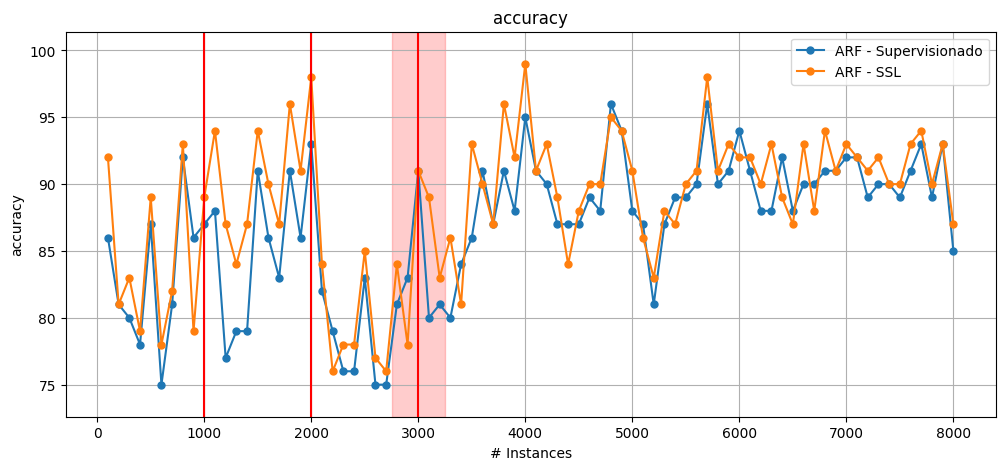

In [141]:
# Rótulos para os gráficos
result_prequential_ARF.learner = "ARF - Supervisionado"
result_ssl_prequential_ARF.learner = "ARF - SSL"

# Plot dos resultados
plot_windowed_results(
    result_prequential_ARF, 
    result_ssl_prequential_ARF, 
    metric="accuracy"
)

# Avaliando um único fluxo usando múltiplos Algoritmos

## Implementação Própria

Este *loop* implementa uma metodologia de avaliação *prequencial* (test-then-train) para múltiplos modelos simultaneamente.

A lógica funciona da seguinte forma:

1.  **Iteração Única (Stream):** O *loop* `while` avança instância por instância (`count`) pelo *stream* de dados.
2.  **Iteração Dinâmica (Modelos):** Para **cada** instância (ex: `Instância 0`), um *loop* `for` interno passa essa mesma instância por **todos** os modelos definidos no dicionário `models_to_test`.
3.  **Estado Encapsulado:** O dicionário armazena o "estado" de cada modelo (o próprio modelo, seus detectores de *drift* e suas listas de resultados).
4.  **Lógica Unificada:** Dentro do `for`, a lógica de `predict()`, `train()`, e detecção de *drift* é aplicada individualmente a cada modelo antes de avançar para a próxima instância do *stream*.

Isso garante que todos os modelos sejam treinados e avaliados exatamente sob as mesmas condições, na mesma ordem de dados.

### Hiperparâmetros

Os hiperparâmetros dos modelos devem ser ajustados no arquivo ``py/models.py``

In [28]:
from py.models import get_models

MAX_INSTANCES = 10000
WINDOW_SIZE = 500
DELAY_LENGTH = 500
LABEL_PROBABILITY = 0.75

# Para alterar entre as streams sintética e real
# stream = CICDDoS2019
stream = streams["Robust_Drift"]
print(stream.get_schema())

@relation 'generators.RandomRBFGenerator '

@attribute att1 numeric
@attribute att2 numeric
@attribute att3 numeric
@attribute att4 numeric
@attribute att5 numeric
@attribute att6 numeric
@attribute att7 numeric
@attribute att8 numeric
@attribute att9 numeric
@attribute att10 numeric
@attribute class {class1,class2}

@data


### Supervisionado


Modelo: LeveragingBagging
  Accuracy: 77.3700
  F1_Score: 76.8044
  Precision: 76.8936
  Recall: 76.7154
  Kappa: 53.5968
  Kappa_m: 46.6651
  Kappa_t: 52.2171


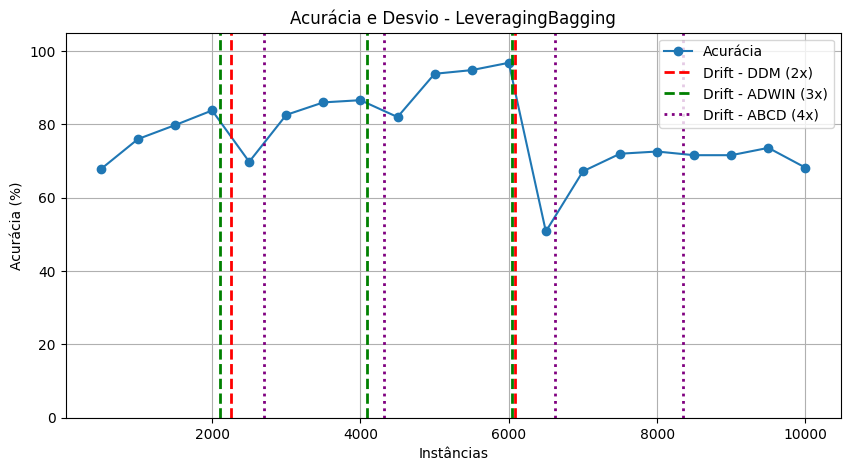


Modelo: HoeffdingAdaptiveTree
  Accuracy: 68.9500
  F1_Score: 67.9218
  Precision: 68.2267
  Recall: 67.6197
  Kappa: 35.6995
  Kappa_m: 26.8206
  Kappa_t: 34.4383


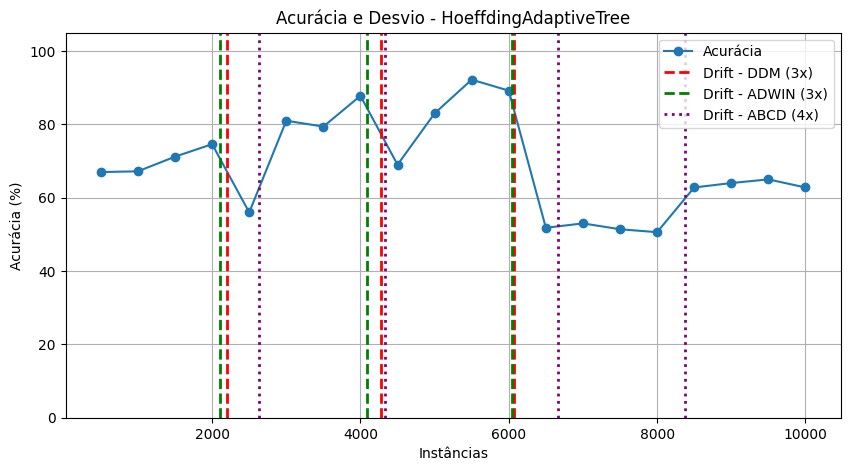


Modelo: AdaptiveRandomForest
  Accuracy: 81.5000
  F1_Score: 80.9746
  Precision: 81.6564
  Recall: 80.3041
  Kappa: 61.5778
  Kappa_m: 56.3988
  Kappa_t: 60.9375


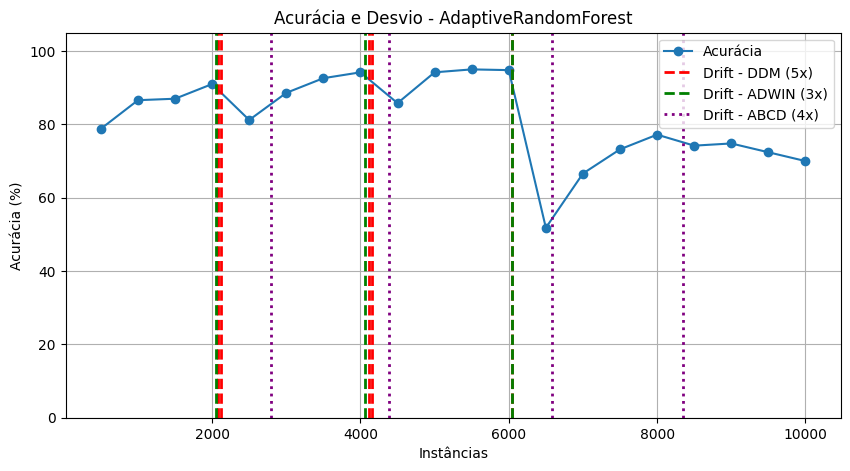


Modelo: HoeffdingTree
  Accuracy: 70.4800
  F1_Score: 69.6961
  Precision: 69.7990
  Recall: 69.5936
  Kappa: 39.3718
  Kappa_m: 30.4266
  Kappa_t: 37.6689


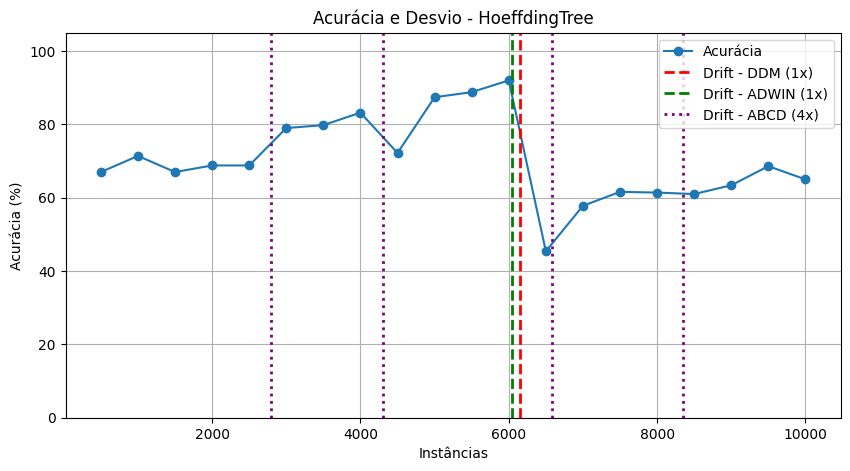

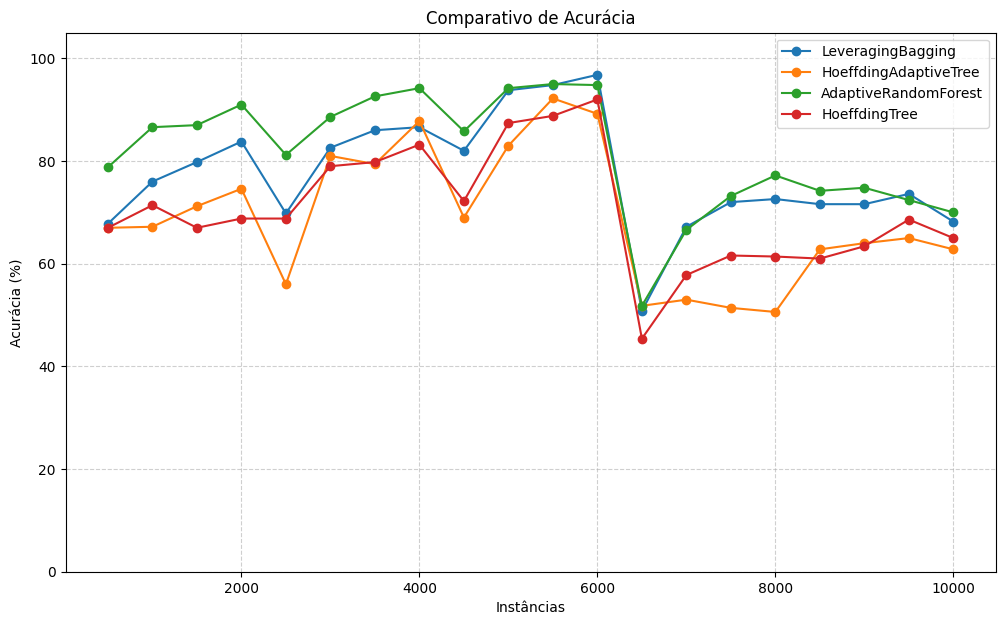

In [32]:
models_to_test = get_models(stream.schema, WINDOW_SIZE, delay_length=DELAY_LENGTH)
instance_count_history = [] 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    # Verifica se estamos no final de uma janela (para plotar)
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    # Itera sobre cada modelo e aplica a mesma lógica
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        # Predict
        prediction = model.predict(instance)
        try:
            prediction_value = prediction[0]
        except (IndexError, TypeError):
            prediction_value = prediction 
        
        # Evaluate 
        state["evaluator"].update(instance.y_index, prediction_value)
        
        # Error (para Drifts e Acurácia de Janela)
        error = 0 if prediction_value == instance.y_index else 1
        state["window_errors"].append(error)
        
        # Drift Detection (DDM)
        state["drift_ddm"].add_element(error)
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        # Drift Detection (ADWIN)
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        # Drift Detection (ABCD)
        state["drift_ABCD"].add_element(instance)
        if state["drift_ABCD"].detected_change():
            state["results_drift_ABCD"].append(count)
            state["drift_ABCD"].reset()
            
        # Train
        model.train(instance)
        
        # Coleta de Acurácia (na borda da janela)
        if is_window_boundary:
            if state["window_errors"]:
                mean_error = np.mean(state["window_errors"])
                accuracy_pct = (1.0 - mean_error) * 100
                state["results_accuracy"].append(accuracy_pct)
            else:
                state["results_accuracy"].append(100.0)
            
            state["window_errors"].clear() # Lógica de janela "tumbling"
            
    # Adiciona ao eixo X compartilhado
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1


# Resultados Cumulativos 
for model_name, state in models_to_test.items():
    print(f"\nModelo: {model_name}")
    print(f"  Accuracy: {state['evaluator'].accuracy():.4f}")
    print(f"  F1_Score: {state['evaluator'].f1_score():.4f}")
    print(f"  Precision: {state['evaluator'].precision():.4f}")
    print(f"  Recall: {state['evaluator'].recall():.4f}")
    print(f"  Kappa: {state['evaluator'].kappa():.4f}")
    print(f"  Kappa_m: {state['evaluator'].kappa_m():.4f}")
    print(f"  Kappa_t: {state['evaluator'].kappa_t():.4f}")
    # print(f"  Metrics: {state['evaluator'].metrics()}")
    # print(f"  Metrics_dict: {state['evaluator'].metrics_dict()}")
    # print(f"  Metrics_header: {state['evaluator'].metrics_header()}")
    # print(f"  Metrics_per_window: {state['evaluator'].metrics_per_window()}")

    plt.figure(figsize=(10, 5))
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label='Acurácia')
    drift_count_ddm = len(state['results_drift_ddm'])
    drift_count_adwin = len(state['results_drift_adwin'])
    drift_count_ABCD = len(state["results_drift_ABCD"])
    plt.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='r', linestyle='--', 
               linewidth=2, label=f'Drift - DDM ({drift_count_ddm}x)')
    plt.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='g', linestyle='--', 
               linewidth=2, label=f'Drift - ADWIN ({drift_count_adwin}x)')
    plt.vlines(x=state['results_drift_ABCD'], ymin=0, ymax=105, color='purple', linestyle=':', 
               linewidth=2, label=f'Drift - ABCD ({drift_count_ABCD}x)')
    plt.title(f'Acurácia e Desvio - {model_name}')
    plt.xlabel('Instâncias')
    plt.ylabel('Acurácia (%)')
    plt.ylim(0, 105) 
    plt.grid(True)
    plt.legend()
    plt.show()

# Gráfico Comparativo (Apenas Acurácia)
plt.figure(figsize=(12, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label=model_name)
plt.title('Comparativo de Acurácia')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

### Semi-supervised Learning (SSL)


Modelo: LeveragingBagging
  Accuracy: 84.8125
  F1_Score: 84.0590
  Precision: 85.1121
  Recall: 83.0317
  Kappa: 67.6272
  Kappa_m: 62.0905
  Kappa_t: 68.3099

Modelo: HoeffdingAdaptiveTree
  Accuracy: 84.4250
  F1_Score: 83.6348
  Precision: 84.5388
  Recall: 82.7498
  Kappa: 66.8837
  Kappa_m: 61.1232
  Kappa_t: 67.5013

Modelo: AdaptiveRandomForest
  Accuracy: 85.1125
  F1_Score: 84.3755
  Precision: 85.3785
  Recall: 83.3958
  Kappa: 68.3003
  Kappa_m: 62.8393
  Kappa_t: 68.9358

Modelo: HoeffdingTree
  Accuracy: 84.0000
  F1_Score: 83.2230
  Precision: 84.5743
  Recall: 81.9142
  Kappa: 65.7046
  Kappa_m: 60.0624
  Kappa_t: 66.6145


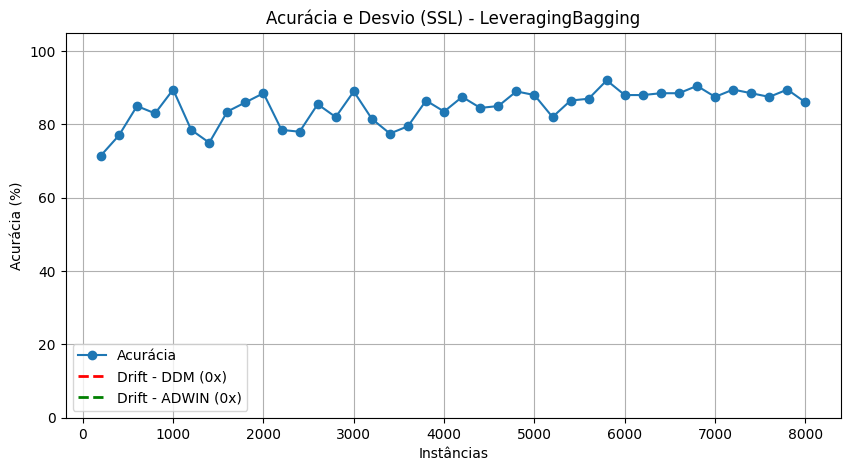

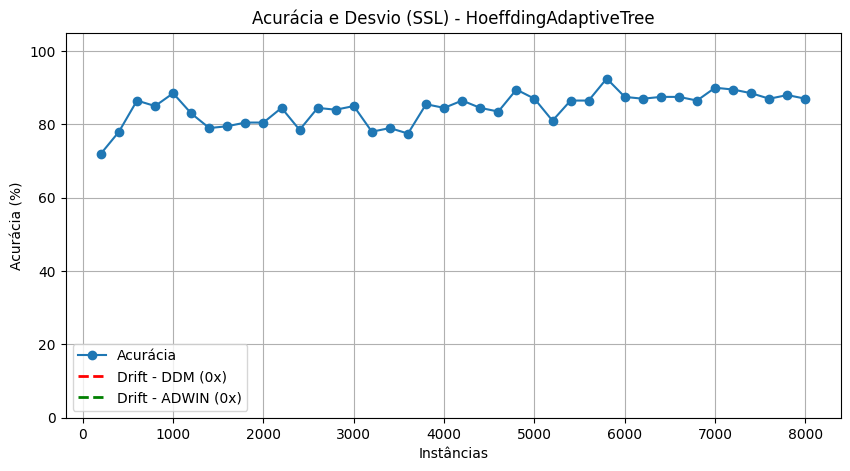

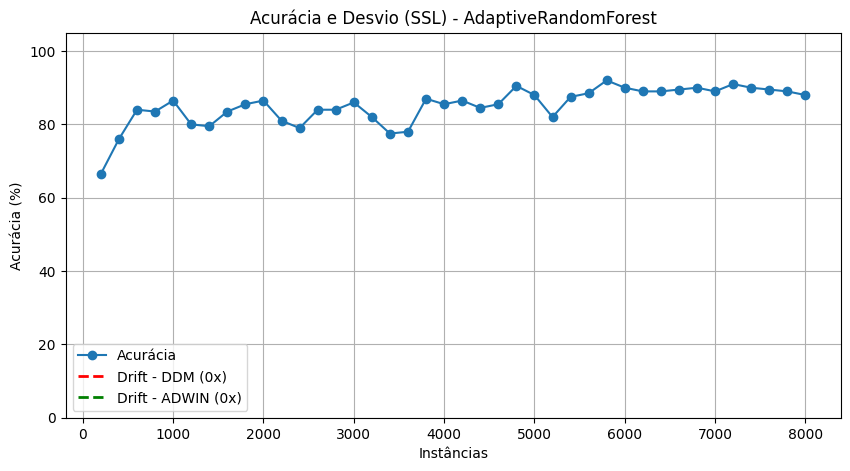

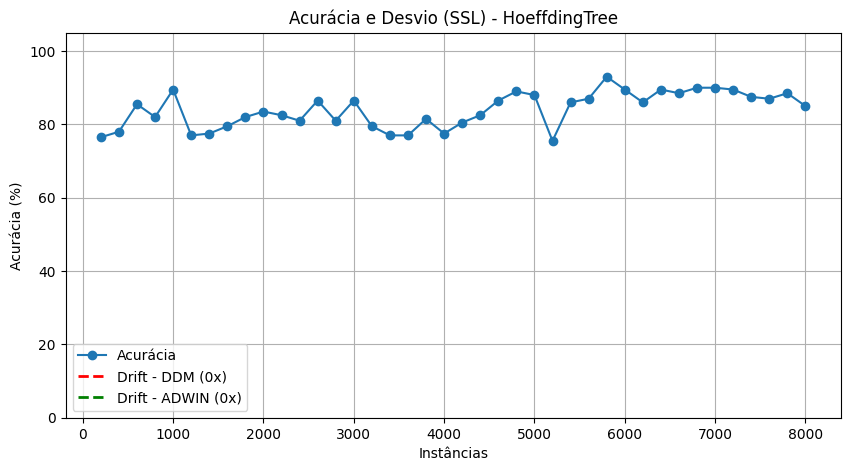

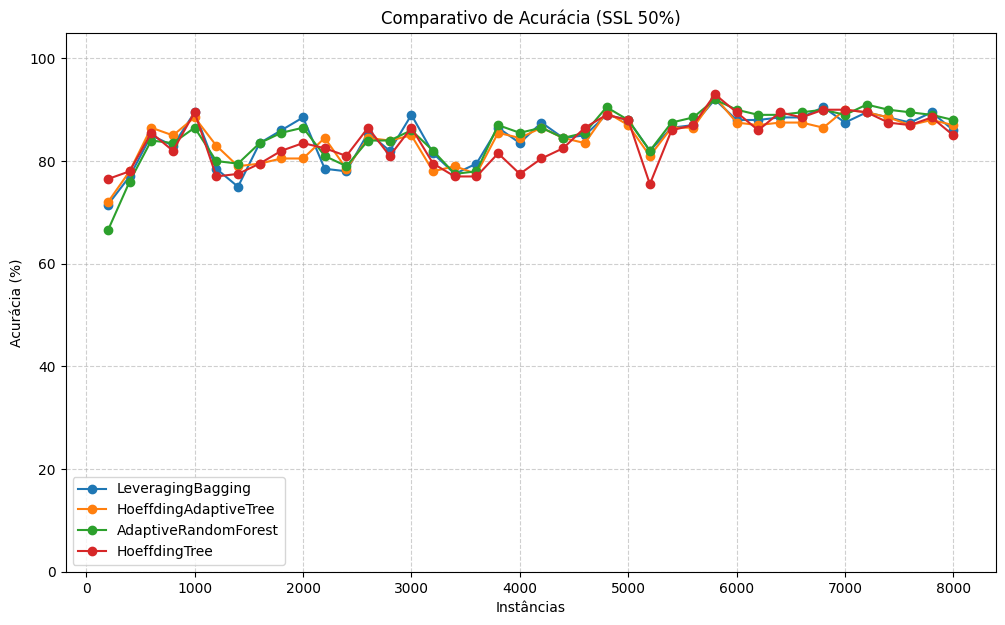

In [186]:
models_to_test = get_models(stream.schema, WINDOW_SIZE, delay_length=DELAY_LENGTH)
instance_count_history = [] 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        try:
            prediction_value = prediction[0]
        except (IndexError, TypeError):
            prediction_value = prediction 
        
        state["evaluator"].update(instance.y_index, prediction_value)
        
        error = 0 if prediction_value == instance.y_index else 1
        state["window_errors"].append(error)
        
        state["drift_ddm"].add_element(error)
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        # Drift Detection (ABCD)
        state["drift_ABCD"].add_element(instance)
        if state["drift_ABCD"].detected_change():
            state["results_drift_ABCD"].append(count)
            state["drift_ABCD"].reset()
            
        # O modelo só treina se o "sorteio" (random) permitir
        if random.random() <= LABEL_PROBABILITY:
            model.train(instance)

        if is_window_boundary:
            if state["window_errors"]:
                mean_error = np.mean(state["window_errors"])
                accuracy_pct = (1.0 - mean_error) * 100
                state["results_accuracy"].append(accuracy_pct)
            else:
                state["results_accuracy"].append(100.0)
            
            state["window_errors"].clear() 
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

# Resultados Cumulativos 
for model_name, state in models_to_test.items():
    print(f"\nModelo: {model_name}")
    print(f"  Accuracy: {state['evaluator'].accuracy():.4f}")
    print(f"  F1_Score: {state['evaluator'].f1_score():.4f}")
    print(f"  Precision: {state['evaluator'].precision():.4f}")
    print(f"  Recall: {state['evaluator'].recall():.4f}")
    print(f"  Kappa: {state['evaluator'].kappa():.4f}")
    print(f"  Kappa_m: {state['evaluator'].kappa_m():.4f}")
    print(f"  Kappa_t: {state['evaluator'].kappa_t():.4f}")
    # print(f"  Metrics: {state['evaluator'].metrics()}")
    # print(f"  Metrics_dict: {state['evaluator'].metrics_dict()}")
    # print(f"  Metrics_header: {state['evaluator'].metrics_header()}")
    # print(f"  Metrics_per_window: {state['evaluator'].metrics_per_window()}")

for model_name, state in models_to_test.items():
    plt.figure(figsize=(10, 5))
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label='Acurácia')
    drift_count_ddm = len(state['results_drift_ddm'])
    drift_count_adwin = len(state['results_drift_adwin'])
    plt.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='r', linestyle='--', 
               linewidth=2, label=f'Drift - DDM ({drift_count_ddm}x)')
    plt.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='g', linestyle='--', 
               linewidth=2, label=f'Drift - ADWIN ({drift_count_adwin}x)')
    plt.title(f'Acurácia e Desvio (SSL) - {model_name}')
    plt.xlabel('Instâncias')
    plt.ylabel('Acurácia (%)')
    plt.ylim(0, 105) 
    plt.grid(True)
    plt.legend()
    plt.show()

plt.figure(figsize=(12, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label=model_name)
plt.title(f'Comparativo de Acurácia (SSL {LABEL_PROBABILITY*100:.0f}%)')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

### SSL com Delay


Modelo: LeveragingBagging
  Accuracy: 80.3375
  F1_Score: 79.3426
  Precision: 79.7166
  Recall: 78.9722
  Kappa: 58.5917
  Kappa_m: 50.8898
  Kappa_t: 58.8112

Modelo: HoeffdingAdaptiveTree
  Accuracy: 80.1625
  F1_Score: 79.3121
  Precision: 79.3571
  Recall: 79.2672
  Kappa: 58.6225
  Kappa_m: 50.4527
  Kappa_t: 58.4446

Modelo: AdaptiveRandomForest
  Accuracy: 81.2125
  F1_Score: 80.2970
  Precision: 80.5831
  Recall: 80.0130
  Kappa: 60.5379
  Kappa_m: 53.0752
  Kappa_t: 60.6441

Modelo: HoeffdingTree
  Accuracy: 80.9125
  F1_Score: 80.0411
  Precision: 80.1851
  Recall: 79.8977
  Kappa: 60.0666
  Kappa_m: 52.3259
  Kappa_t: 60.0157


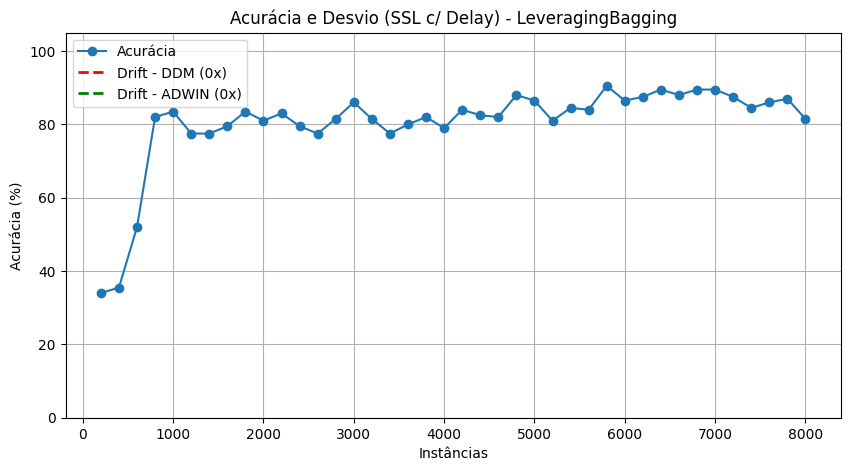

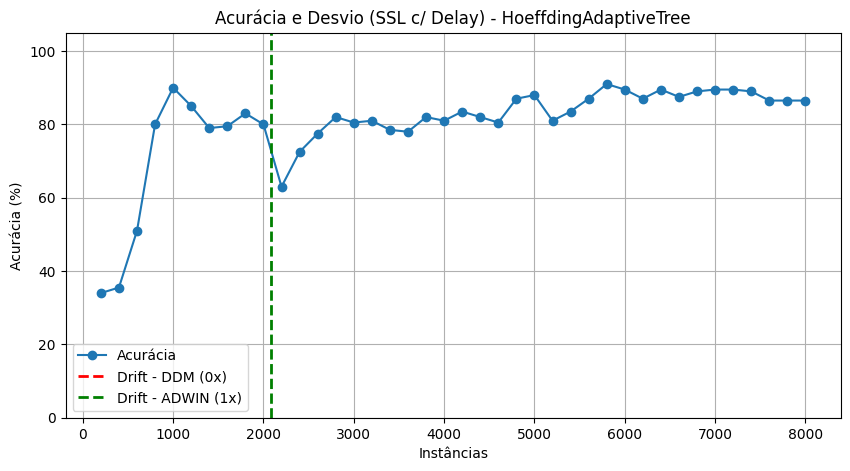

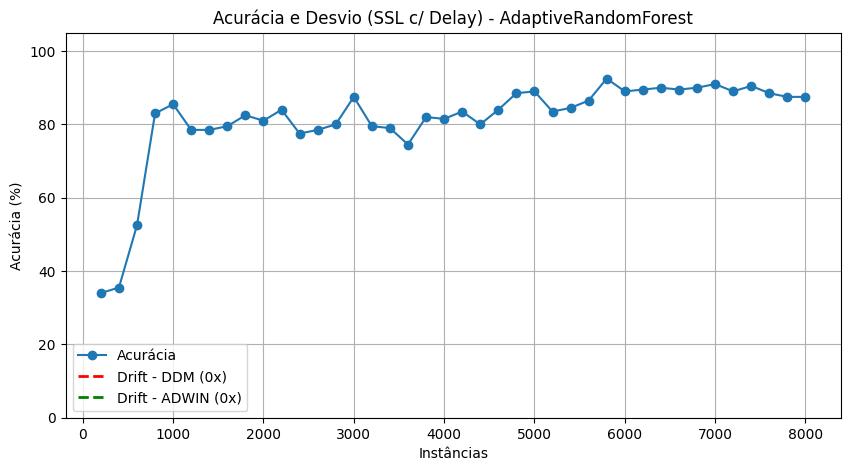

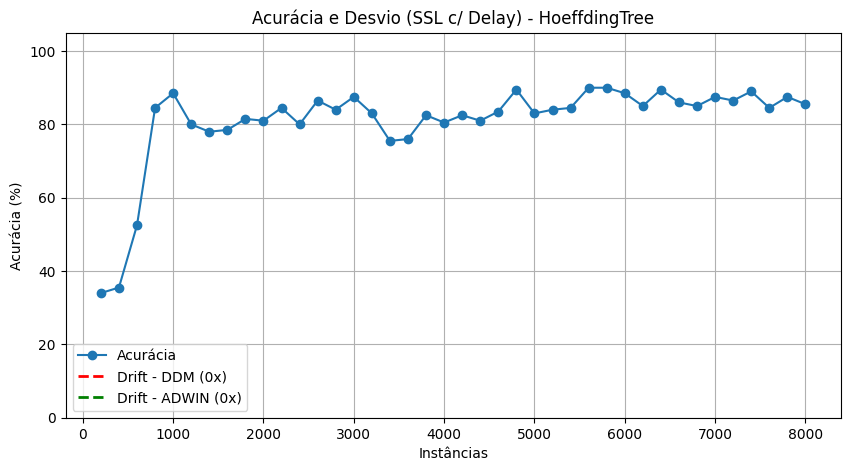

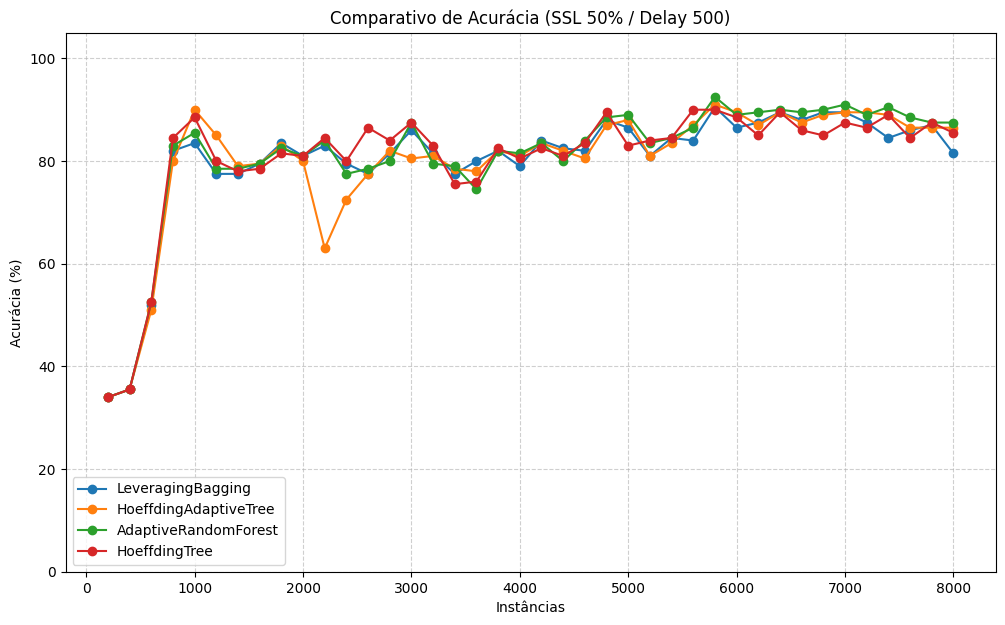

In [187]:
models_to_test = get_models(stream.schema, WINDOW_SIZE, delay_length=DELAY_LENGTH)
instance_count_history = [] 
count = 0

stream.restart() 
while stream.has_more_instances() and count < MAX_INSTANCES:
    instance = stream.next_instance()
    
    is_window_boundary = (count + 1) % WINDOW_SIZE == 0
    
    for model_name, state in models_to_test.items():
        model = state["model_instance"] 
        
        prediction = model.predict(instance)
        try:
            prediction_value = prediction[0]
        except (IndexError, TypeError):
            prediction_value = prediction 
        
        state["evaluator"].update(instance.y_index, prediction_value)
        
        error = 0 if prediction_value == instance.y_index else 1
        state["window_errors"].append(error)
        
        state["drift_ddm"].add_element(error)
        if state["drift_ddm"].detected_change():
            state["results_drift_ddm"].append(count)
            state["drift_ddm"].reset()
            
        state["drift_adwin"].add_element(error)
        if state["drift_adwin"].detected_change():
            state["results_drift_adwin"].append(count)
            state["drift_adwin"].reset()

        # Drift Detection (ABCD)
        state["drift_ABCD"].add_element(instance)
        if state["drift_ABCD"].detected_change():
            state["results_drift_ABCD"].append(count)
            state["drift_ABCD"].reset()
        
        # Armazenar na fila 
        queue = state["prediction_queue"] # Pega a fila específica deste modelo
        if random.random() <= LABEL_PROBABILITY:
            queue.append(instance) # Armazena a instância se o rótulo estiver disponível
        else:
            queue.append(None)     # Armazena None para manter o timing do delay
            
        # Treinar com Atraso (Lógica do Delay)
        if len(queue) == DELAY_LENGTH:
            delayed_item = queue.popleft() # Pega o item mais antigo
            
            if delayed_item is not None:
                # Só treina se o item não for None (ou seja, se o rótulo foi salvo)
                model.train(delayed_item)

        if is_window_boundary:
            if state["window_errors"]:
                mean_error = np.mean(state["window_errors"])
                accuracy_pct = (1.0 - mean_error) * 100
                state["results_accuracy"].append(accuracy_pct)
            else:
                state["results_accuracy"].append(100.0)
            
            state["window_errors"].clear() 
            
    if is_window_boundary:
        instance_count_history.append(count + 1)
        
    count += 1

# Resultados Cumulativos 
for model_name, state in models_to_test.items():
    print(f"\nModelo: {model_name}")
    print(f"  Accuracy: {state['evaluator'].accuracy():.4f}")
    print(f"  F1_Score: {state['evaluator'].f1_score():.4f}")
    print(f"  Precision: {state['evaluator'].precision():.4f}")
    print(f"  Recall: {state['evaluator'].recall():.4f}")
    print(f"  Kappa: {state['evaluator'].kappa():.4f}")
    print(f"  Kappa_m: {state['evaluator'].kappa_m():.4f}")
    print(f"  Kappa_t: {state['evaluator'].kappa_t():.4f}")
    # print(f"  Metrics: {state['evaluator'].metrics()}")
    # print(f"  Metrics_dict: {state['evaluator'].metrics_dict()}")
    # print(f"  Metrics_header: {state['evaluator'].metrics_header()}")
    # print(f"  Metrics_per_window: {state['evaluator'].metrics_per_window()}")

for model_name, state in models_to_test.items():
    plt.figure(figsize=(10, 5))
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label='Acurácia')
    drift_count_ddm = len(state['results_drift_ddm'])
    drift_count_adwin = len(state['results_drift_adwin'])
    plt.vlines(x=state['results_drift_ddm'], ymin=0, ymax=105, color='r', linestyle='--', 
               linewidth=2, label=f'Drift - DDM ({drift_count_ddm}x)')
    plt.vlines(x=state['results_drift_adwin'], ymin=0, ymax=105, color='g', linestyle='--', 
               linewidth=2, label=f'Drift - ADWIN ({drift_count_adwin}x)')
    plt.title(f'Acurácia e Desvio (SSL c/ Delay) - {model_name}')
    plt.xlabel('Instâncias')
    plt.ylabel('Acurácia (%)')
    plt.ylim(0, 105) 
    plt.grid(True)
    plt.legend()
    plt.show()


plt.figure(figsize=(12, 7))
for model_name, state in models_to_test.items():
    plt.plot(instance_count_history, state['results_accuracy'], 'o-', label=model_name)
plt.title(f'Comparativo de Acurácia (SSL {LABEL_PROBABILITY*100:.0f}% / Delay {DELAY_LENGTH})')
plt.xlabel('Instâncias')
plt.ylabel('Acurácia (%)')
plt.ylim(0, 105)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.show()

## capyMOA

### Modelos

In [43]:
from capymoa.classifier import LeveragingBagging
from capymoa.classifier import HoeffdingAdaptiveTree
from capymoa.classifier import AdaptiveRandomForestClassifier

HAT = HoeffdingAdaptiveTree(
    schema=stream.schema,
    random_seed=0, # Padrão (0)
    grace_period=200, # Padrão (200)
    split_criterion='InfoGainSplitCriterion', # Padrão ('InfoGainSplitCriterion')
    confidence=0.01, # Padrão (0.01)
    tie_threshold=0.05, # Padrão (0.05)
    leaf_prediction='NaiveBayesAdaptive',
    nb_threshold=0, # Padrão (0)
    numeric_attribute_observer='GaussianNumericAttributeClassObserver', # Padrão ('GaussianNumericAttributeClassObserver')
    binary_split=False, # Padrão (False)
    max_byte_size=33554432, # Padrão (32MB)
    memory_estimate_period=1000000, # Padrão (1.000.000)
    stop_mem_management=True, # Padrão (True)
    remove_poor_attrs=False, # Padrão (False)
    disable_prepruning=True # Padrão (True)
)

LB = LeveragingBagging(
    schema=stream.schema, 
    CLI=None, # Padrão (None)
    random_seed=1, # Padrão (1)
    base_learner=None, # Padrão (None)
    ensemble_size=100, # Padrão (100)
    minibatch_size=None, # Padrão (None)
    number_of_jobs=None # Padrão (None)
)

ARF = AdaptiveRandomForestClassifier(
    schema=stream.schema,
    CLI=None, # Padrão (None)
    random_seed=1, # Padrão (1)
    base_learner=None, # Padrão (None)
    ensemble_size=100, # Padrão (100)
    max_features=0.6, # Padrão (0.6)
    lambda_param=6.0, # Padrão (6.0)
    minibatch_size=None, # Padrão (None)
    number_of_jobs=1, # Padrão (1)
    drift_detection_method=None, # Padrão (None)
    warning_detection_method=None, # Padrão (None)
    disable_weighted_vote=False, # Padrão (False)
    disable_drift_detection=False, # Padrão (False)
    disable_background_learner=False # Padrão (False)        
)

### Avaliação

LB accuracy = 98.11042419738072 
HAT accuracy = 99.21962095875139 
ARF accuracy = 99.72298233167798


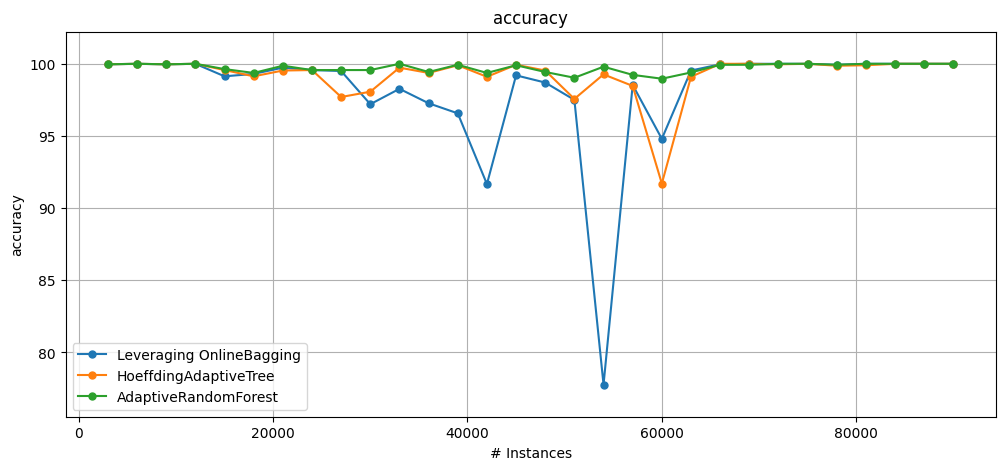

In [44]:
from capymoa.evaluation import prequential_evaluation_multiple_learners
from capymoa.evaluation.visualization import plot_windowed_results

learners = {
    "LB": LB,
    "HAT": HAT,
    "ARF": ARF
}

stream.restart()
results = prequential_evaluation_multiple_learners(stream, learners, window_size=3000)

print(f"LB accuracy = {results['LB'].cumulative.accuracy()} \nHAT accuracy = {results['HAT'].cumulative.accuracy()} \nARF accuracy = {results['ARF'].cumulative.accuracy()}")
plot_windowed_results(results["LB"], results["HAT"], results["ARF"], metric="accuracy")